# **ASSIGNMENT 6**
---

# **Name:** Prashant Agheda
# **PRN No:** 20210804004
# **Subject:** Advanced AI

---

## **Topic:** ACTIVE CONTOUR-BASED SEGMENTATION TECHNIQUES.

## **Aim:** Implement Snake model, Gradient Vector Flow, Balloon Model, Geometric and Geodesic Active Contour Model.

### **Steps To Perform:**

## **1. Snake Model**

In [ ]:
# Importing required Libraries.

import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage import data, segmentation, img_as_float
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.io import imread, imshow
from google.colab.patches import cv2_imshow

In [ ]:
# Read the image data.

vegetableImage = imread("/content/Vegetable_Image.png")

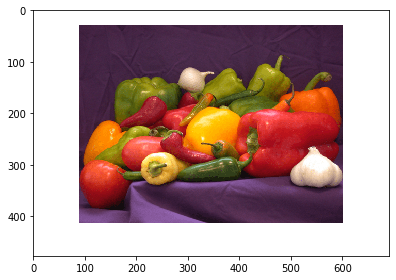

In [ ]:
# Displaying the Image.

imshow(vegetableImage)

In [ ]:
# Convert the image into grayscale.

vegetableImage = rgb2gray(vegetableImage)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  This is separate from the ipykernel package so we can avoid doing imports until


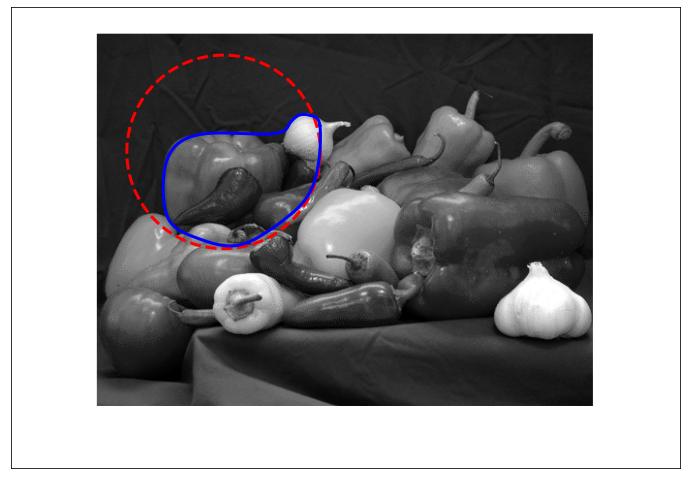

In [ ]:

img = vegetableImage

s = np.linspace(0, 2*np.pi, 400)
r = 150 + 100*np.sin(s)
c = 220 + 100*np.cos(s)
init = np.array([r, c]).T


snake = active_contour(gaussian(img, 3, preserve_range = False),
                       init, alpha = 0.040, beta = 10, gamma = 0.001)


fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img, cmap = plt.cm.gray)

ax.plot(init[:, 1], init[:, 0], '--r', lw = 3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw = 3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()

## **Observations:**

- Snake model mainly works to identify and outlines the target object considered for segmentation inside specific selected area.
- Above we have read the image, converted it into Grayscale and then applied Gaussian Blur filter.
- After that we have used **active_contour** method for implementing snake model.
- We can play around with the values of **alpha** which tells that how fast the **contraction** by our snake should be done and **beta** tells that how **smooth** our snake should be.



---



## **2. Gradient vector flow**


In [ ]:
import sys

In [ ]:
def gradientVectorFlow(fX, fY, mu, dX=1.0, dY=1.0, verbose=False):
    
    # calculate gradient vector flow of input gradient field fx, fy
    # calculate some coefficients
    b = fX**2.0 + fY**2.0
    c1, c2 = b*fX, b*fY

    # calculate dt from scaling parameter r
    # (17) r < 1/4 required for convergence
    r = 0.25
    dT = dX*dY / (r*mu)

    # maximum iteration
    N = int(max(1, np.sqrt(vegetableImage.shape[0] * vegetableImage.shape[1])))

    # initialize u(x, y), v(x, y) by the input
    currentU = fX
    currentV = fY


    def laplacian(m):
        return np.hstack([m[:, 0:1], m[:, :-1]]) + np.hstack([m[:, 1:], m[:, -2:-1]]) \
                + np.vstack([m[0:1, :], m[:-1, :]]) + np.vstack([m[1:, :], m[-2:-1, :]]) \
                - 4*m


    for i in range(N):
        nextU = (1.0 - b*dT) * currentU + r * laplacian(currentU) + c1 * dT
        nextV = (1.0 - b*dT) * currentV + r * laplacian(currentV) + c2 * dT
        currentU, currentV = nextU, nextV

        if verbose:
            sys.stdout.write(".")
            sys.stdout.flush()

    if verbose:
        sys.stdout.write("\n")

    return currentU, currentV


def gradientField(img):
    img = gaussian(img, 1.0)
    gradientX = np.hstack([img[:, 1:], img[:, -2:-1]]) - np.hstack([img[:, 0:1], img[:, :-1]]) 
    gradientY = np.vstack([img[1:, :], img[-2:-1, :]]) - np.vstack([img[0:1, :], img[:-1, :]]) 
    return gradientX, gradientY


H, W = vegetableImage.shape
Y, X = np.meshgrid(range(0, H, 5), range(0, W, 5))

def plotVectorField(ax, vX, vY):
    scale = np.sqrt(np.max(vX**2 + vY**2)) * 20.0

    ax.imshow(vegetableImage, cmap = "gray")

    ax.quiver(X, Y, vX[Y, X], -vY[Y, X], scale = scale, color = "red", headwidth = 5)

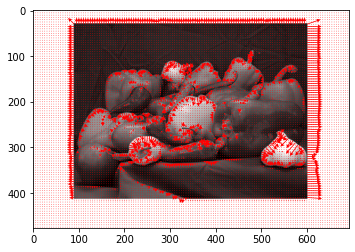

In [ ]:
fX, fY = gradientField(vegetableImage)
gradientX, gradientY = (gradientVectorFlow(fX, fY, mu = 1.0))

figure, ax = plt.subplots(1, 1)
plotVectorField(ax, fX, fY)



---



## **3. Balloon model**

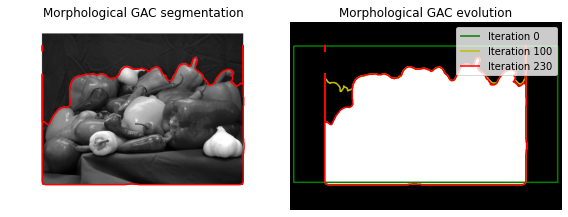

In [ ]:
def store_evolution_in(myList):
  # Returns a callback function to store the evolution of the level sets in the given list.

    def _store(x):
        myList.append(np.copy(x))

    return _store


figure, ax = plt.subplots(1, 2, figsize = (8, 8))
ax = ax.flatten()

# Morphological GAC
img = vegetableImage
gaussianImage = segmentation.inverse_gaussian_gradient(img)

# Initial level set
initLs = np.zeros(img.shape, dtype = np.int8)
initLs[60:-70, 10:-10] = 1

# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = segmentation.morphological_geodesic_active_contour(gaussianImage, iterations=230,
                                           init_level_set=initLs,
                                           smoothing=1, balloon=-0.71,
                                           threshold=0.65,
                                           iter_callback=callback)

ax[0].imshow(img, cmap = "gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors = "r")
ax[0].set_title("Morphological GAC segmentation", fontsize = 12)

ax[1].imshow(ls, cmap = "gray")
ax[1].set_axis_off()

contour = ax[1].contour(evolution[0], [0.5], colors="g")
contour.collections[0].set_label("Iteration 0")
contour = ax[1].contour(evolution[100], [0.5], colors="y")
contour.collections[0].set_label("Iteration 100")
contour = ax[1].contour(evolution[-1], [0.5], colors="r")
contour.collections[0].set_label("Iteration 230")
ax[1].legend(loc="upper right")
title = "Morphological GAC evolution"
ax[1].set_title(title, fontsize=12)

figure.tight_layout()
plt.show()



---



## **4. Geometric or Geodesic active contour model**

/usr/local/lib/python3.7/dist-packages/skimage/segmentation/morphsnakes.py:106: FutureWarning: circle_level_set is deprecated in favor of disk_level_set.circle_level_set will be removed in version 0.19
  res = circle_level_set(image_shape)
/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


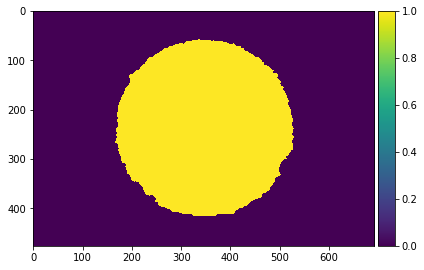

In [ ]:
geometricActiveContourModel = segmentation.morphological_geodesic_active_contour(vegetableImage, iterations = 10)

# Displaying the Image
imshow(geometricActiveContourModel)



---

